# Supplementary figure 3

This notebook contains the functions used to construct the supplementary figure 3 in the paper. 

The aim of this plot is show that the decreased exonic mutation burden is observed across groups of genes with increasing mutation rate.

The figure contains 5 panels that corresponds to 5 pairs of tumor type and cluster. For each pair two plots are obtained:

- Decrease of exonic mutation burden across groups of genes grouped by mutaton rate (on the left panel)
- Distribution of mutation rate within each group (on the right panel)

---

The data required for each panel is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from os import path
from scipy.stats import chi2

from python_scripts.plot_functions import config_plot_params

In [2]:
%matplotlib inline

In [3]:
config_plot_params()

## Input

- clusters_of_tumors: pairs of cluster and tumor to be analysed
- n_groups: amount of groups to make to group genes by mutation rate
---

In addition, this notebook requires the output of **gene_and_sample_analysis** notebook.

In [4]:
# Colorectal and uterine MSH-H, bMMRD POLE and POLD-mutant and uterine POLE-mutant
clusters_of_tumors = [('crc', 'clusterB'), ('ucec', 'clusterA'), ('bMMRD', 'clusterA'), ('bMMRD', 'clusterB'), ('ucec', 'clusterE')]  

n_groups = 10

## Mutation burden

Compute the expected and observed number of mutations in exons and introns, and for sysnonymous and non-synonymous mutations for each gene. The method is described in the **Test for negative selection on exonic mutations** section in the paper.

Note that the computation is the same as in **figure2** notebook and the output has the same name.

In [5]:
def compute_mutation_burden(tumor_type, cluster_id):
    """compute mutation burden at gene level for each tumor and cluster pair"""
    
    exon_intron_results_lol = list()
    syn_nonsyn_results_lol = list()

    gene_dependent_results = path.join('results', "%s_%s_gene_dependent_results.txt" % (tumor_type, cluster_id) )
    sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (tumor_type, cluster_id) )

    genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
    samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')

    my_genelevel_exp = list()

    for my_gene in set(genelvl_results_df['ensembl']):
        sub_genelvl_results = genelvl_results_df[genelvl_results_df['ensembl'] == my_gene]
        sub_samplelvl_results = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]

        exons_products_sum = sub_genelvl_results['exons_products_sum'].values[0]
        introns_products_sum = sub_genelvl_results['introns_products_sum'].values[0]

        exons_prob = exons_products_sum/(exons_products_sum+introns_products_sum)
        introns_prob = introns_products_sum/(exons_products_sum+introns_products_sum)

        exon_muts = sum(sub_samplelvl_results['obs_exon_muts'])
        intron_muts = sum(sub_samplelvl_results['obs_intron_muts'])

        total_muts = exon_muts+intron_muts

        exp_exon_muts = total_muts*exons_prob
        exp_intron_muts = total_muts*introns_prob

        syn_products_sum = sub_genelvl_results['syn_products_sum'].values[0]
        nonsyn_products_sum = sub_genelvl_results['nonsyn_products_sum'].values[0]

        syn_prob = syn_products_sum/(syn_products_sum+nonsyn_products_sum)
        nonsyn_prob = nonsyn_products_sum/(syn_products_sum+nonsyn_products_sum)

        syn_muts = sum(sub_samplelvl_results['obs_syn_muts'])
        nonsyn_muts = sum(sub_samplelvl_results['obs_nonsyn_muts'])

        total_cons_muts = syn_muts+nonsyn_muts

        exp_syn_muts = total_cons_muts*syn_prob
        exp_nonsyn_muts = total_cons_muts*nonsyn_prob

        my_genelevel_exp.append([my_gene, exon_muts, exp_exon_muts, intron_muts,
                                 exp_intron_muts, syn_muts, nonsyn_muts, exp_syn_muts,
                                 exp_nonsyn_muts])

    my_genelevel_exp_df = pd.DataFrame(my_genelevel_exp)
    my_genelevel_exp_df.columns = ['ensembl', 'exon_muts', 'exp_exon_muts', 'intron_muts',
                                   'exp_intron_muts', 'syn_muts', 'nonsyn_muts', 'exp_syn_muts',
                                   'exp_nonsyn_muts']

    genel_lvl_df = pd.merge(genelvl_results_df, my_genelevel_exp_df, on='ensembl')

    genel_lvl_df.to_csv(path.join('results', "%s_%s_obs_exp_syn_nonsym_muts.tsv" % (tumor_type, cluster_id)), 
                        sep="\t", header=True, index=False)

In [6]:
for pair in clusters_of_tumors:
    print('\t'.join(pair))
    compute_mutation_burden(*pair)

crc	clusterB
ucec	clusterA
bMMRD	clusterA
bMMRD	clusterB
ucec	clusterE


## Decreased exonic mutation burden

Group genes by their mutation rate (mutations divided by the total base pairs) and compute the decrease in exonic mutation burden for each group.

Genes without mutations have been excluded.

In [7]:
def compute_pval(obs_muts_1, obs_muts_2, exp_muts1_prob):
    """likelihood ratio test"""
    
    y = obs_muts_1
    N = obs_muts_1 + obs_muts_2
    p1 = y/N  # probability of going exon according to the observed exon/intron muts

    p0 = exp_muts1_prob  # expected probability of going exon
    
    logL1 = y*np.log(p1)+(N-y)*np.log(1-p1) #log likelihood according to p1
    logL0 = y*np.log(p0)+(N-y)*np.log(1-p0) #log likelihood according to p0
        
    my_chi2 = 2*(logL1-logL0)
    
    my_p = chi2.sf(my_chi2, 1) #chi2 score to pvalue
    
    return my_p

def compute_decrease_mut_burden(tumor_type, cluster_id, n_groups):
    """Group genes by mutation rate and compute the decrease in mutation burden"""
    
    sub_results = pd.read_csv(path.join('results', "%s_%s_obs_exp_syn_nonsym_muts.tsv" % (tumor_type, cluster_id)), 
                              sep="\t")

    # Exclude genes with mut_rate = 0
    sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                                (sub_results['exons_bp'] + sub_results['introns_bp']))
    sub_results = sub_results.sort_values(by='mutrate', ascending=True)
    sub_results = sub_results[sub_results['mutrate'] != 0]

    groups_size = int(len(sub_results.index.tolist()) / n_groups)

    mutrate_levels = dict()

    # list genof each group
    for i in range(n_groups):
        my_start = i * groups_size
        my_end = (i + 1) * groups_size

        if i == max(range(n_groups)):
            my_end = len(sub_results.index.tolist())

        sub_exin_prop_df = sub_results.iloc[my_start:my_end]
        sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()

        mutrate_levels[i] = sub_exin_genes

    exons_results_prop = list()

    for mutrate_level in mutrate_levels:
        genes_list = mutrate_levels[mutrate_level]
        
        exons_bp = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exons_bp'])

        obs_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exon_muts'])
        obs_intron_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['intron_muts'])

        total_muts = obs_exon_muts+obs_intron_muts

        obs_exons_rate = obs_exon_muts/exons_bp

        exp_exon_muts = sum(sub_results[sub_results['ensembl'].isin(genes_list)]['exp_exon_muts'])
        exp_exons_rate = exp_exon_muts/exons_bp

        decrease_over_expected = -(exp_exons_rate-obs_exons_rate)/exp_exons_rate*100

        exp_exon_prob = exp_exon_muts/total_muts
        pval = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)

        exons_results_prop.append([mutrate_level, decrease_over_expected, pval])

    results_prop_df = pd.DataFrame(exons_results_prop)
    results_prop_df.columns = ['bin', 'decrease_over_expected', 'pval']

    results_prop_df.to_csv(path.join('results', "%s_%s_mut_burden_mut_rate.tsv" % (tumor_type, cluster_id)), 
                           sep="\t", header=True, index=False)

In [8]:
for pair in clusters_of_tumors:
    print('\t'.join(pair))
    compute_decrease_mut_burden(*pair, n_groups)

crc	clusterB
ucec	clusterA
bMMRD	clusterA
bMMRD	clusterB
ucec	clusterE


### Left panels

Decrease in exonic mutation burden based on genes grouped by mutation rate

In [9]:
def plot_decreased_mutation_burden(tumor_type, cluster_id):

    mut_rate_df = pd.read_csv(path.join('results', "%s_%s_mut_burden_mut_rate.tsv" % (tumor_type, cluster_id)), sep="\t")

    fig = plt.figure(figsize=(3.5, 1.25))
    ax1 = plt.subplot2grid((1, 1), (0, 0))

    # for the significant ones
    tmp1 = mut_rate_df[mut_rate_df['pval'] < 0.05]
    x = np.array(tmp1['bin'].tolist()) + 1
    y = tmp1['decrease_over_expected'].tolist()
    ax1.plot(x, y, '.', label='exon_mutrate', color='#810f7c', markersize=8)

    # for the non-significant ones
    tmp1 = mut_rate_df[mut_rate_df['pval'] >= 0.05]
    x = np.array(tmp1['bin'].tolist()) + 1
    y = tmp1['decrease_over_expected'].tolist()
    ax1.plot(x, y, '.', label='exon_mutrate', color='#8c96c6', markersize=8)

    ax1.set_ylim(-70, 70)
    ax1.set_yticks([-60, -30, -0, 30, 60])
    
    ax1.set_facecolor('none')
    #ax1.set_ylabel('Decreased exonic mutation burden')
    ax1.set_xlabel('Mutation rate bins (lower to higher)')

    loc = plticker.MultipleLocator(base=1) 
    ax1.xaxis.set_major_locator(loc)

    # show the left spline
    for axis in ['right', 'top']:
        ax1.spines[axis].set_visible(False)

    for axis in ['bottom', 'left']:
        ax1.spines[axis].set_position(('axes', -0.01))

    ax1.margins(0.05)

    #ax1.yaxis.major.locator.set_params(nbins=4)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    plt.savefig(path.join('figures', 'figureS3_{}_{}_burden.svg'.format(tumor_type, cluster_id)))
    plt.show()

crc	clusterB


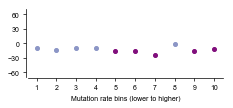

ucec	clusterA


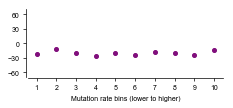

bMMRD	clusterA


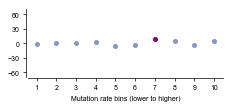

bMMRD	clusterB


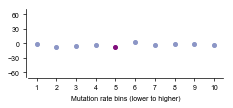

ucec	clusterE


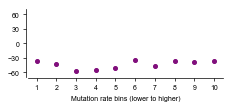

In [10]:
for pair in clusters_of_tumors:
    print('\t'.join(pair))
    plot_decreased_mutation_burden(*pair)

## Mutation rate

Compute the mutation rate of each gene and group them by that value.

In [11]:
def compute_mutation_rate(tumor_type, cluster_id, n_groups):
    """Group genes by mutation rate and identify the value"""
    
    sub_results = pd.read_csv(path.join('results', "%s_%s_obs_exp_syn_nonsym_muts.tsv" % (tumor_type, cluster_id)), 
                                  sep="\t") 
    
    # Exclude genes with mut_rate = 0
    sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                                (sub_results['exons_bp'] + sub_results['introns_bp']))
    sub_results = sub_results.sort_values(by='mutrate', ascending=True)
    sub_results = sub_results[sub_results['mutrate'] != 0]

    groups_size = int(len(sub_results.index.tolist()) / n_groups)
    
    mutrate_levels = dict()

    # list genof each group
    for i in range(n_groups):
        my_start = i * groups_size
        my_end = (i + 1) * groups_size

        if i == max(range(n_groups)):
            my_end = len(sub_results.index.tolist())

        sub_exin_prop_df = sub_results.iloc[my_start:my_end]
        sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()

        mutrate_levels[i] = sub_exin_genes
        
    
    genes_mutrate_bin_lol = list()

    for mutrate_level in mutrate_levels:
        genes_list = mutrate_levels[mutrate_level]

        for my_gene in genes_list:
            gene_mutrate = sub_results[sub_results['ensembl'] == my_gene]['mutrate'].values[0]

            genes_mutrate_bin_lol.append([my_gene, mutrate_level, gene_mutrate])

    genes_mutrate_bin_df = pd.DataFrame(genes_mutrate_bin_lol)
    genes_mutrate_bin_df.columns = ['ensembl', 'mutrate_level', 'gene_mutrate']
    
    genes_mutrate_bin_df.to_csv(path.join('results', "%s_%s_mut_rate_groups.tsv" % (tumor_type, cluster_id)), 
                           sep="\t", header=True, index=False)

In [12]:
for pair in clusters_of_tumors:
    print('\t'.join(pair))
    compute_mutation_rate(*pair, n_groups)

crc	clusterB
ucec	clusterA
bMMRD	clusterA
bMMRD	clusterB
ucec	clusterE


### Right panels

Distribution of mutation rate of genes in each bin

In [13]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

In [14]:
def plot_mutation_rate(tumor_type, cluster_id):

    genes_mutrate_bin_df = pd.read_csv(path.join('results', "%s_%s_mut_rate_groups.tsv" % (tumor_type, cluster_id)), sep="\t")
    
    mutrates_to_plot = list()

    for mutrate_bin in list(set(genes_mutrate_bin_df['mutrate_level'])):
        my_mutrates = genes_mutrate_bin_df[genes_mutrate_bin_df['mutrate_level']
                                           == mutrate_bin]['gene_mutrate'].tolist()

        mutrates_to_plot.append(my_mutrates)
        

    fig = plt.figure(figsize=(3.5, 1.15))
    ax = plt.subplot2grid((1, 1), (0, 0))

    # Create the boxplot
    bp = ax.boxplot(mutrates_to_plot, showfliers=False)

    ax.set_ylabel('Mutation rate (mutation / bp)')
    ax.set_xlabel('Mutation rate (lower to higher)')

    ax.margins(0.05)

    for axis in ['right', 'top']:
        ax.spines[axis].set_visible(False)

    for axis in ['bottom', 'left']:
        ax.spines[axis].set_position(('axes', -0.01))

    ax.yaxis.major.locator.set_params(nbins=4)
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.savefig(path.join('figures', 'figureS3_{}_{}_rate.svg'.format(tumor_type, cluster_id)))
    plt.show()

crc	clusterB


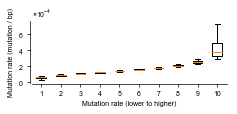

ucec	clusterA


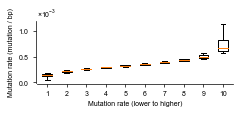

bMMRD	clusterA


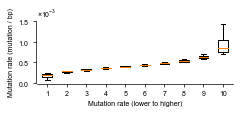

bMMRD	clusterB


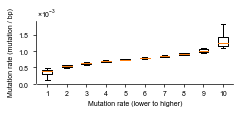

ucec	clusterE


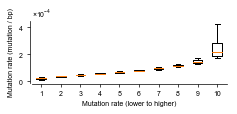

In [15]:
for pair in clusters_of_tumors:
    print('\t'.join(pair))
    plot_mutation_rate(*pair)